In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from numpy.linalg import solve, norm
from scipy.integrate import quad_vec
from scipy.integrate import quad
from numpy.linalg import matrix_rank
import math
import scipy

In [60]:
'''Defined Functions'''

def get_domain_partition(degree, n_elem, x_min, x_max, bc_x_min='flux', bc_x_max='flux'):
    #assert degree == 1
    # Local node numbering on parent domain
    # --0--------------1---->
    #  -1      0      +1    zeta
    gnodes_x = np.linspace(x_min, x_max, n_elem+1, dtype=np.float64)
    patches = list()
    local_to_global_node_id_map = list()
    for e in range(n_elem):
        gnode_id_2 = e + 1            # right
        gnode_id_1 = gnode_id_2 - 1   # left
        x1 = gnodes_x[gnode_id_1]
        x2 = gnodes_x[gnode_id_2]
        # Local node id:  0   1
        patches.append((x1, x2))
        # Local node id:                        0           1
        local_to_global_node_id_map.append([gnode_id_1, gnode_id_2])
    if bc_x_min == 'essential':
        local_to_global_node_id_map[0][0] = -1
    if bc_x_max == 'essential':
        local_to_global_node_id_map[-1][-1] = -1
    return (patches, gnodes_x, local_to_global_node_id_map)

def get_parent_mapping():
    # zeta in [-1,1]
    parent_mapping = lambda zeta, x_e_bar, h_e: x_e_bar + h_e/2*zeta # compute x
    parent_mapping_prime = lambda h_e: h_e/2                         # compute mapping derivative wrt zeta
    # x in Omega_e
    inverse_parent_mapping = lambda x, x_e_bar, h_e: (x - x_e_bar)*2/h_e # compute zeta
    return (parent_mapping, parent_mapping_prime, inverse_parent_mapping)

def get_parent_basis_functions():
    parent_basis_func_list = list()
    parent_basis_func_prime_list = list()
    parent_basis_func_list.append(lambda zeta: -(zeta-1)/2)  # left
    parent_basis_func_list.append(lambda zeta:  (zeta+1)/2)  # right
    parent_basis_func_prime_list.append(lambda zeta: -1/2) # left
    parent_basis_func_prime_list.append(lambda zeta:  1/2) # right
    
    return (parent_basis_func_list, parent_basis_func_prime_list)

def global_basis_function(i, x, domain_partition, parent_mapping, parent_basis_functions):
    """Evaluate the ith global FE basis function and its derivative on x points.
    
    This is never needed in practice. It is here for demonstrating the theory.
    """
    try:
        len(x)
    except TypeError:
        x = np.array([x])
  
    if not isinstance(x, np.ndarray):
       assert isinstance(x, list) or isinstance(x, tuple)
       x = np.array(x)
  
    phi_i_x = np.copy(x) * 0.0 # initialization
    phi_prime_i_x = np.copy(x) * 0.0 # initialization
        
    patches = domain_partition[0]
    local_to_global_node_id_map = domain_partition[2]
    inverse_parent_mapping = parent_mapping[2]
    parent_basis_func_list = parent_basis_functions[0]
  
    # expensive reverse lookup
    for j, x_j in enumerate(x):
        for e, nodes_x in enumerate(patches):
            if nodes_x[0] <= x_j <= nodes_x[1]:
                n_lnodes = len(nodes_x)
                for I in range(n_lnodes):
                    if local_to_global_node_id_map[e][I] == i:
                        x_e_bar = (nodes_x[0] + nodes_x[1])/2
                        h_e = nodes_x[1] - nodes_x[0]
                        zetta = inverse_parent_mapping(x_j, x_e_bar, h_e)
                        phi_i_x[j] = parent_basis_func_list[I](zetta)
                break
    return phi_i_x

def get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function):
    
    basis_func_list = []
    n_gnodes = domain_partition[1].size
    local_to_global_node_id_map = domain_partition[2]
    phi_i = lambda i, x: global_basis_function(i,x, domain_partition, parent_mapping, parent_basis_functions)

    visited = [False]*n_gnodes
    for e in range(n_elem):
        for I in range(len(local_to_global_node_id_map[e])):
            gnode_id = local_to_global_node_id_map[e][I]
            if gnode_id >= 0 and not visited[gnode_id]:
                      basis_func_list.append(lambda x, i=gnode_id: phi_i(i,x))
                      visited[gnode_id] = True

    assert len(basis_func_list) >= 1, 'There are no basis functions to build.'

    return basis_func_list

def plot(title='Lagrange Basis Functions'):
    
    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.style.use('classic')
    plt.figure(1, figsize=(14, 5))

    npts = 200
    x_pts = np.linspace(x_min, x_max, npts)
    for (i,phi_i) in enumerate(phi_list):
        plt.plot(x_pts, phi_i(x_pts),'-',label=r'$\phi_%i$'%i)

    gnodes_x = domain_partition[1]
    plt.scatter(gnodes_x, np.zeros(gnodes_x.size), color='red', marker='x', s=80, label='nodes')

    plt.title(title, fontsize=20)
    plt.ylabel(r'$\phi_i(x)$', fontsize=18)
    plt.xlabel(r'$x$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()

def FourierBasis(x,N,shift_fourier,Kappa):
    function=np.zeros((len(x),2*N+1))
    for i in range (len(x)):
        for j in range((2*N+1)):
            if (j==0):
                function[i,j]=1
            elif (j%2)==1:
                function[i,j]=np.cos(((j//2)+1)*Kappa*(x[i]-shift_fourier))
            elif (j%2)==0:
                function[i,j]=np.sin((j//2)*Kappa*(x[i]-shift_fourier))
    return np.array(function)

def Plot(function,x_pts):
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(5)
    plt.style.use('classic')
    for i in range(len(function[0])):
        if i==0:
            plt.plot(x_pts,function[:,0],label='1')
        elif i%2==1:
            plt.plot(x_pts,function[:,i], label=r'$cos$(%ik(${x}$ - $\bar{x}$))'%(((i/2)+0.5)))
        elif i % 2 == 0:
            plt.plot(x_pts,function[:,i], label=r'$sin$(%ik(${x}$ - $\bar{x}$))'%(i/2))
        for _ in range(len(function[0])//2):
            plt.legend( bbox_to_anchor=(1.05, 1.0),loc='best')
    plt.xlabel(r'$X$',fontsize = 19)
    plt.ylabel(r'$Cos x, Sin x$',fontsize=19)
    plt.title('Fourier basis func at Mode = %i'%N, fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    return plt.show()


In [61]:
'''Domain'''

x_a = 0
x_b = 25

In [62]:
'''Parameters and data'''

diff_coeff = 0.1
source_slope_value = -1e-2

u_a_0 = 3.5  # initial value
u_b_0 = 3.5  # initial value

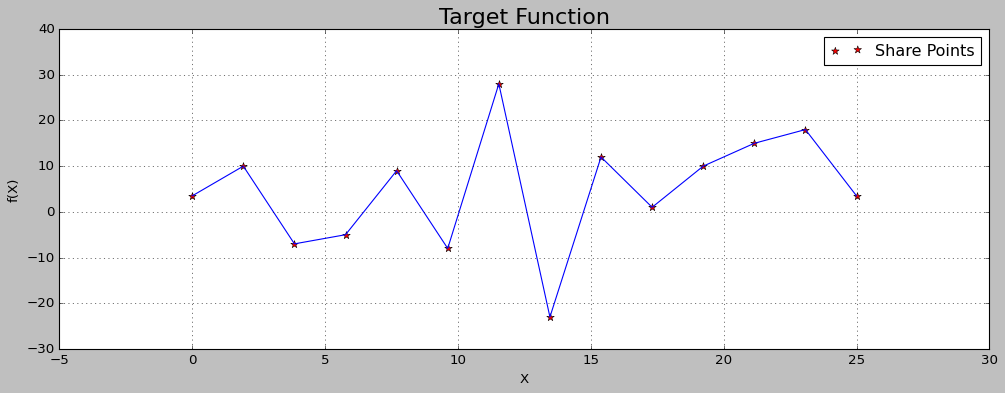

In [63]:
'''Generate the scaffolding of the manufactured solution'''

shape_pts_y = [u_a_0,10,-7,-5,9,-8,28,-23,12,1,10,15,18,u_b_0]
shape_pts_x = [x for x in np.linspace(x_a, x_b, len(shape_pts_y))]
shape_pts = list(zip(shape_pts_x, shape_pts_y))

def TargetFunction(x,y,markersize):
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(5)
    plt.style.use('classic')
    plt.plot(x,y)
    p1=plt.scatter(x,y,marker = '*',s=markersize,edgecolors = 'black', linewidth=.5,c = 'red')
    plt.legend([p1],['Share Points'],scatterpoints=2,loc ="upper right")
    plt.xlabel('X')
    plt.ylabel('f(X)')
    plt.title('Target Function', fontsize=20)
    plt.rcParams.update({'font.size': 18})
    plt.grid()
    return plt


f = TargetFunction(shape_pts_x,shape_pts_y,markersize = 50)

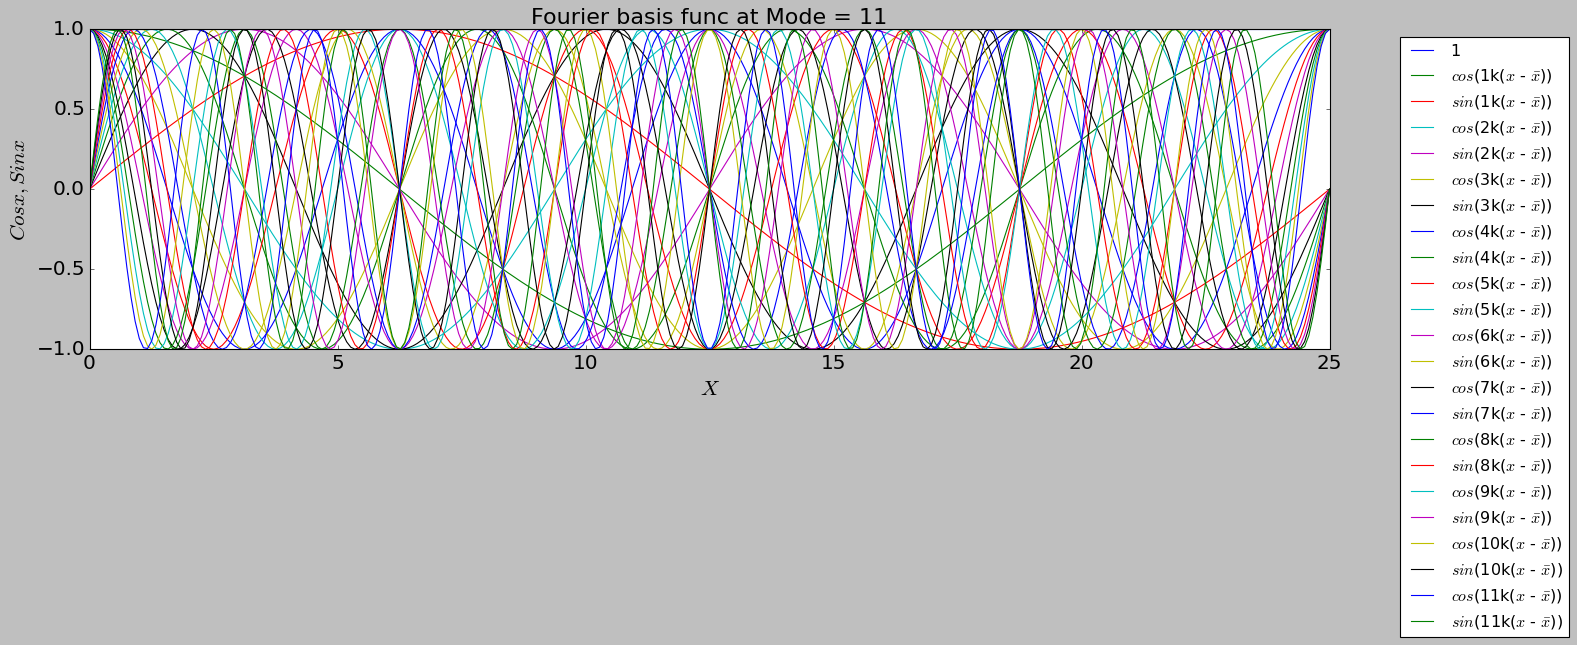

In [64]:
'''Build the basis functions list'''
m= 300
shift_fourier=0
wavelength = x_b -x_a
kappa = 2*math.pi/wavelength
x_tilde_pts = np.linspace(x_a,x_b,m)
u = interpolate.interp1d(shape_pts_x, shape_pts_y, kind='linear',fill_value='array-like')


N=11

fb = FourierBasis(x_tilde_pts,N,shift_fourier,kappa)
Plot(fb,x_tilde_pts)


In [65]:
'''Functions for Gram Matrix'''

def index_hand_fourier(p):
    t0=0
    if p>=1:
        for _ in range(p):
            t0 += 2*N+1
    return t0

def FourierBasis_single(x_pts,j,K,shift_fourier):
    if (j==0):
        mat=1
    elif (j%2)==1:
        mat=np.cos(((j//2)+1)*K*(x_pts-shift_fourier))
    elif (j%2)==0:
        mat=np.sin((j//2)*K*(x_pts-shift_fourier))
    return mat

def derivative_FourierBasis_single(x_pts,j,K,shift_fourier):
    if (j==0):
        mat = 0
    elif (j%2)==1:
        mat = -(((j//2)+1)*K*np.sin(((j//2)+1)*K*(x_pts-shift_fourier)))
    elif (j%2)==0:
        mat = (((j//2)+1)*K*np.cos((j//2)*K*(x_pts-shift_fourier)))
    return mat

def FourierBasis_matrix(x_pts,N,K,shift_fourier):
    matrix = np.zeros((len(x_pts),2*N+1))
    for i in range (len(x_pts)):
        for j in range((2*N+1)):
            matrix = FourierBasis_single(x_pts[i],j,K,shift_fourier)
    return np.array(matrix)

def derivative_g_c(x,i,j,K,shift_fourier):
    return derivative_FourierBasis_single(
        x, i, K, shift_fourier
    ) * derivative_FourierBasis_single(x, j, K, shift_fourier)

def g_c(x,i,j,K,shift_fourier):
    return FourierBasis_single(x, i, K, shift_fourier) * FourierBasis_single(
        x, j, K, shift_fourier
    )

def f_das(x):
    dx = np.array(10**(-6))
    return ((u(x+dx)-u(x))/dx)

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
def Fourierbasis_gram_matrix(N,K,x_min,x_max,shift_fourier):
    gram_matrx_con = np.zeros(((np.sum(2*N)+1),(np.sum(2*N)+1)))
    for p in range(1):
        for i in range(2*N+1):
            for j in range(2*N+1):
                gram_matrx_con[int(index_hand_fourier(p)+i),int(index_hand_fourier(p)+j)] = (quad(g_c,x_min,x_max,args = (i,j,K,shift_fourier), limit = 10000)[0])+g_c(x_min,i,j,K,shift_fourier)+g_c(x_max,i,j,K,shift_fourier)+derivative_g_c(x_min,i,j,K,shift_fourier)+derivative_g_c(x_max,i,j,K,shift_fourier)
    return gram_matrx_con

def Load_vec_con(x,i,K,shift_fourier):
    return (FourierBasis_single(x,i,K,shift_fourier)*u(x))

def derivative_Load_vec_con(x,i,K,shift_fourier):
    return (derivative_FourierBasis_single(x,i,K,shift_fourier)*u(x))

def Fourier_load_vector(N,K,x_min,x_max,shift_fourier):
    b_vec_c =np.zeros((np.sum(2*N)+1))
    for i in range(2*N + 1):
        b_vec_c[i] = (quad(Load_vec_con, x_min, x_max, args = (i,K,shift_fourier), limit = 10000)[0])+Load_vec_con(x_min,i,K,shift_fourier)+Load_vec_con(x_max,i,K,shift_fourier)+derivative_Load_vec_con(x_min,i,K,shift_fourier)+derivative_Load_vec_con(x_max,i,K,shift_fourier)
    return b_vec_c

def bestg_vec_func_con(x,N,c_star_vec_con,K,shift_fourier):
    a_mtrx = FourierBasis(x,N,shift_fourier,K)
    return a_mtrx@c_star_vec_con

In [66]:
'''Build the Gram matrix'''

fourierbasis_gram_matrix = Fourierbasis_gram_matrix(N,kappa,x_a,x_b,shift_fourier)


In [67]:
'''Build load vector'''

fourier_load_vector = Fourier_load_vector(N,kappa,x_a,x_b,shift_fourier)


if fourierbasis_gram_matrix.shape[0] > fourierbasis_gram_matrix.shape[1]:
    print('G is overdetermined.')
elif fourierbasis_gram_matrix.shape[0] < fourierbasis_gram_matrix.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

if matrix_rank(fourierbasis_gram_matrix) == min(fourierbasis_gram_matrix.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

C:\Users\ashis\AppData\Local\Temp/ipykernel_5496/758749855.py:67: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  b_vec_c[i] = (quad(Load_vec_con, x_min, x_max, args = (i,K,shift_fourier), limit = 10000)[0])+Load_vec_con(x_min,i,K,shift_fourier)+Load_vec_con(x_max,i,K,shift_fourier)+derivative_Load_vec_con(x_min,i,K,shift_fourier)+derivative_Load_vec_con(x_max,i,K,shift_fourier)


G is determined.
G is full rank.


In [68]:
'''Compute optimal coefficient vector'''

beta_vec = solve(fourierbasis_gram_matrix,fourier_load_vector)

g_best_vec_1=bestg_vec_func_con(x_tilde_pts,N,beta_vec,kappa,shift_fourier)
#print(g_best_vec_1)

In [69]:
def FourierBasis_Mat(x,N,shift_fourier,Kappa):
    function=np.zeros((len(x),2*N+1))
    for i in range (len(x)):
        for j in range((2*N+1)):
            if (j==0):
                function[i,j]=1
            elif (j%2)==1:
                function[i,j]=np.cos(((j//2)+1)*Kappa*(x[i]-shift_fourier))
            elif (j%2)==0:
                function[i,j]=np.sin((j//2)*Kappa*(x[i]-shift_fourier))
    return np.array(function)

def Derivative_FourierBasis_Mat(x,N,shift_fourier,Kappa):
    function = np.zeros((len(x),2*N+1))
    for i in range (len(x)):
        for j in range((2*N+1)):
            if (j==0):
                function[i,j]=0
            elif (j%2)==1:
                function[i,j]=-(((j//2)+1)*Kappa*np.sin(((j//2)*Kappa*(x[i]-shift_fourier))))
            elif (j%2)==0:
                function[i,j]=(((j//2)+1)*Kappa*np.cos((j//2)*Kappa*(x[i]-shift_fourier)))
    return np.array(function)

def Derivative2_FourierBasis_Mat(x,N,shift_fourier,Kappa):
    function = np.zeros((len(x),2*N+1))
    for i in range (len(x)):
        for j in range((2*N+1)):
            if (j==0):
                function[i,j]=0
            elif (j%2)==1:
                function[i,j]=-(((((j//2)+1)*Kappa)**2)*np.cos(((j//2)*Kappa*(x[i]-shift_fourier))))
            elif (j%2)==0:
                function[i,j]=-(((((j//2)+1)*Kappa)**2)*np.sin((j//2)*Kappa*(x[i]-shift_fourier)))
    return np.array(function)

def evaluation_matrix(x,N,shift_fourier,Kappa):
    return FourierBasis_Mat(x,N,shift_fourier,Kappa)

def evaluation_matrix_derivative1(x,N,shift_fourier,Kappa):
    return Derivative_FourierBasis_Mat(x,N,shift_fourier,Kappa)

def evaluation_matrix_derivative2(x,N,shift_fourier,Kappa):
    return Derivative2_FourierBasis_Mat(x,N,shift_fourier,Kappa)


In [70]:
'''Build the best approximant function'''

def u_manufactured(x,N,shift_fourier,Kappa):
    return evaluation_matrix(x,N,shift_fourier,Kappa)@beta_vec

def u_prime_manufactured(x,N,shift_fourier,Kappa):
    return evaluation_matrix_derivative1(x,N,shift_fourier,Kappa)@beta_vec
    
def diff_flux_x_manufactured(x,N,shift_fourier,Kappa):
    return -diff_coeff*u_prime_manufactured(x,N,shift_fourier,Kappa)


<function u_manufactured at 0x0000022446B2F550>


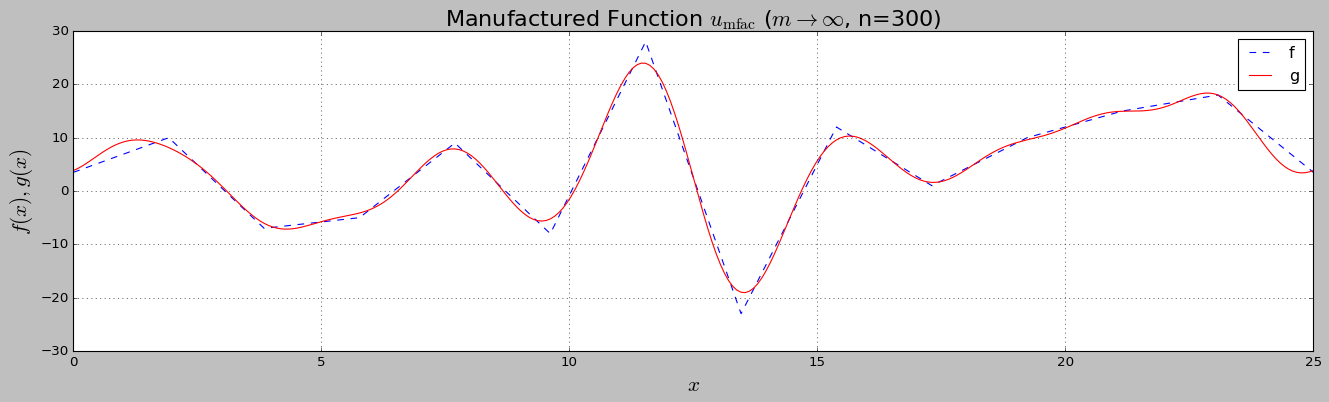

In [71]:
'''Plot comparison of '''

n_pts = 300
x_pts = np.linspace(x_a,x_b,n_pts)
N=11

u_manufactur = u_manufactured(x_pts,N,shift_fourier,kappa)
print(u_manufactured)

def Plot(g_best_vec_1,shape_pts_x,shape_pts_y,x_pts):
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(5)
    plt.style.use('classic')
    
    p1=plt.plot(shape_pts_x,shape_pts_y,'b--',label='f')
    p2=plt.plot(x_pts,g_best_vec_1,'r-',label='g')

    
    plt.title(r'Manufactured Function $u_\mathrm{mfac}$ ($m\rightarrow\infty$, n='+str(len(fb))+')',fontsize=20)
    plt.legend(loc='best')
    plt.xlabel('$x$',fontsize = 19)
    plt.ylabel('$f(x),g(x)$',fontsize = 19)
    plt.rcParams.update({'font.size': 20})
    plt.grid()
    return plt.show()

plot_fourier_best_manfactured = Plot(u_manufactur,shape_pts_x,shape_pts_y,x_pts) 


In [72]:

print('u_mfac(x_a) = ', u_manufactured([x_a]*n_pts,N,shift_fourier,kappa)[0], '; u_a_0 = ', u_a_0)
print('u_mfac(x_b) = ', u_manufactured([x_b]*n_pts,N,shift_fourier,kappa)[0], '; u_b_0 = ', u_b_0)

u_mfac(x_a) =  3.8405613896288466 ; u_a_0 =  3.5
u_mfac(x_b) =  3.8405613896288484 ; u_b_0 =  3.5


In [73]:
print("u'_mfac(x_a) = ", u_prime_manufactured([x_a]*n_pts,N,shift_fourier,kappa)[0])
print("u'_mfac(x_b) = ", u_prime_manufactured([x_b]*n_pts,N,shift_fourier,kappa)[0])

u'_mfac(x_a) =  2.5003238610555525
u'_mfac(x_b) =  2.5003238610555645


In [74]:
'''Update Boundary Condition Values'''

u_a = u_manufactured([x_a]*n_pts,N,shift_fourier,kappa)[0]
u_b = u_manufactured([x_b]*n_pts,N,shift_fourier,kappa)[0]

In [75]:
'''Build the best approximant function'''

def u_prime2_manufactured(x,N,shift_fourier,Kappa):
    return evaluation_matrix_derivative2(x,N,shift_fourier,Kappa)@beta_vec

n_pts = 500

x = np.linspace(x_a, x_b, n_pts)

fin=u_manufactured(x,N,shift_fourier,kappa)

fin2 = u_prime2_manufactured(x,N,shift_fourier,kappa)
print(fin.shape,'\n',fin2.shape)


(500,) 
 (500,)


In [76]:
'''Build the best approximant function'''

def source_bias(x,N,shift_fourier,Kappa):
    return -diff_coeff * u_prime2_manufactured(x,N,shift_fourier,Kappa) - source_slope_value * u_manufactured(x,N,shift_fourier,Kappa)

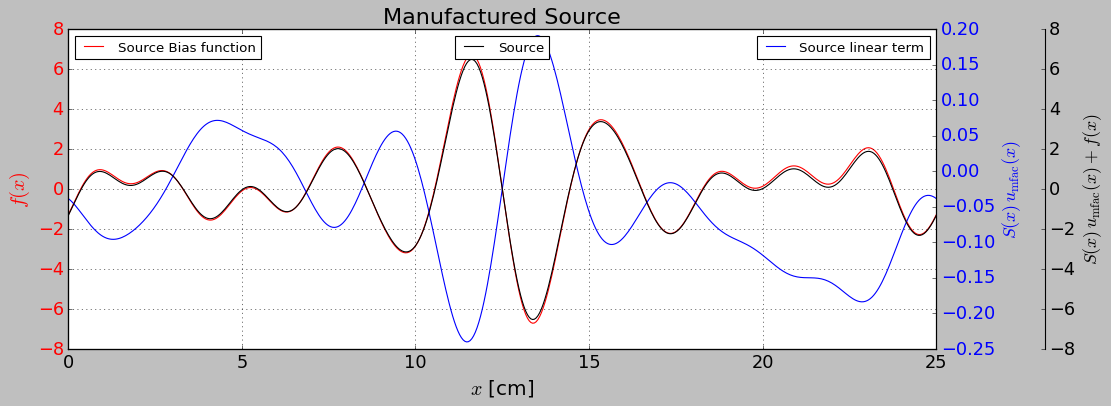

In [77]:
'''Source function'''


n_pts = 500
x = np.linspace(x_a, x_b, n_pts)
f_values = source_bias(x,N,shift_fourier,kappa)
s_u_values = source_slope_value * u_manufactured(x,N,shift_fourier,kappa)

import matplotlib.pyplot as plt

(fig, ax1) = plt.subplots(1, figsize=(14, 5))
ax1.plot(x, f_values, 'r-', label='Source Bias function')
ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
ax1.set_ylabel(r'$f(x)$', fontsize=18, color='red')
ax1.tick_params(axis='y', labelcolor='red', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(x, s_u_values,'-', color='blue', label='Source linear term')
ax2.set_ylabel(r"$S(x)\, u_\mathrm{mfac}(x)$", fontsize=16, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', labelsize=16)
ax2.legend(loc='upper right', fontsize=12)

ax3 = ax1.twinx()
ax3.plot(x, s_u_values+f_values,'-', color='black', label='Source')
ax3.set_ylabel(r"$S(x)\, u_\mathrm{mfac}(x) + f(x)$", fontsize=16, color='black')
ax3.tick_params(axis='y', labelcolor='black', labelsize=16)
ax3.legend(loc='upper center', fontsize=12)
ax3.spines["right"].set_position(("axes", 1.125))

plt.title(r'Manufactured Source', fontsize=20)
plt.show()



In [ ]:
'''Build the lift basis functions'''

degree = 1




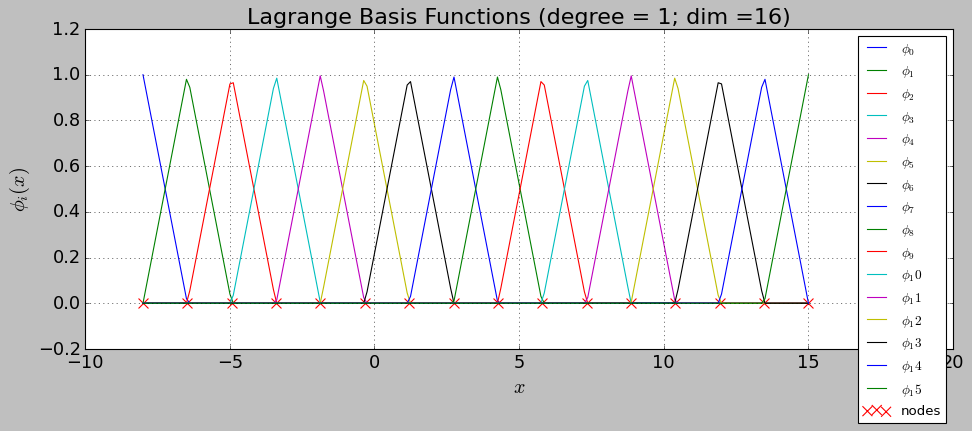

In [78]:
'''Finite element Basis Function'''

import numpy as np
x_min = -8
x_max = 15

degree = 1
n_elem = 15

# It is implied here the boundary conditions are of type: flux
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)

plot(title=r'Lagrange Basis Functions (degree = %i; dim =%i'%(degree, len(phi_list))+')')

In [79]:
'''Build Gram matrix'''

gram


NameError: name 'gram' is not defined